# Double Deep Q Network

In [ ]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import os
import random
import imageio
from tqdm import tqdm  
from itertools import count
from collections import namedtuple,deque

import torch
import torch.nn as nn
import torch.optim as optim


# Hospital Environment

In [ ]:
class RoverGridEnv(gym.Env):
    metadata={'render.modes': ['human']} 
    def __init__(self,max_ts=20):     
        super(RoverGridEnv,self).__init__()
        self.max_ts=max_ts      # Note: The Max_Timestamps is set to 20 by default.
        self.grid_size=(15,15)   
        self.action_space=spaces.Discrete(5) 
        self.observation_space=spaces.MultiDiscrete([15,15,15,15,15,15])
        self.rover_positions=np.array([[6,4],[10,4]])
        self.operation_desks=np.array([[6,3],[10,3]])
        self.rooms=np.array([[4,7],[4,10],[4,13],[8,7],[8,10],[8,13],[12,7],[12,10],[12,13]])
        self.human_position=np.array([8,9])
        self.targets=np.array([[5,10],[9,13]])
        self.actions=[(0,-1),(0,1),(-1,0),(1,0),(0,0)]  # Down,Up,Left,Right,Wait
        self.rover_done=[False,False] 
        self.reset()
    
    def seed(self,seed=None):
        np.random.seed(seed)
        random.seed(seed)
        
    def reset(self):
        self.current_step=0
        self.rover_positions=np.array([[6,4],[10,4]])
        self.rover_done=[False,False]
        self.human_position=np.array([7,8])
        self.current_step=0
        return self._get_obs()
    
    def _get_obs(self):
        return np.concatenate((self.rover_positions.flatten(),self.human_position))
    
    def step(self,actions):
        rewards=np.zeros(2)
        done=[False,False]
        info={'message': ''}        
        for i,action in enumerate(actions):
            if self.rover_done[i]:
                done[i]=True 
                continue
            prev_distance=np.linalg.norm(self.targets[i]-self.rover_positions[i])
            if self._is_human_adjacent(self.rover_positions[i]):
                rewards[i] -= 5
            else:
                delta=np.array(self.actions[action])
                new_position=self.rover_positions[i]+delta
                if self._out_of_bounds(new_position):
                    rewards[i] -= 15
                    continue
                if self._collision(new_position,i):
                    rewards[i] -= 15
                    continue
                self.rover_positions[i]=new_position
                new_distance=np.linalg.norm(self.targets[i]-new_position)
                if new_distance < prev_distance:
                    rewards[i]+=30 
                else:
                    rewards[i] -= 20 
                if np.array_equal(new_position,self.targets[i]):
                    rewards[i]+=100
                    self.rover_done[i]=True 
                    done[i]=True

        # move human randomly
        self._move_human()
        self.current_step+=1
        all_done=all(done) or self.current_step >= self.max_ts
        if all_done and not all(done):  # if the maximum number of steps is reached but not all targets were reached
            info['message']='Maximum number of timestamps reached'
        return self._get_obs(),rewards,all_done,info

    def _is_human_adjacent(self,position):
        for delta in [(1,1),(1,-1),(-1,1),(-1,-1)]:
            adjacent_position=position+np.array(delta)
            if np.array_equal(adjacent_position,self.human_position):
                return True
        return False

    def _out_of_bounds(self,position):
        return not (0 <= position[0] < self.grid_size[0] and 0 <= position[1] < self.grid_size[1])
    
    def _collision(self,new_position,rover_index):
        if any(np.array_equal(new_position,pos) for pos in np.delete(self.rover_positions,rover_index,axis=0)):
            return True  # Collision with the other rover
        if any(np.array_equal(new_position,pos) for pos in self.rooms):
            return True  # Collision with a room
        if any(np.array_equal(new_position,pos) for pos in self.operation_desks):
            return True  # Collision with an operation desk
        if np.array_equal(new_position,self.human_position):
            return True  # Collision with the human
        return False
    
    def _move_human(self):
        valid_moves=[move for move in self.actions if not self._out_of_bounds(self.human_position+np.array(move))]
        self.human_position+=np.array(valid_moves[np.random.choice(len(valid_moves))])
    
    def render(self,mode='human',save_path=None):
        fig,ax=plt.subplots(figsize=(7,7))
        ax.set_xlim(0,self.grid_size[0])
        ax.set_ylim(0,self.grid_size[1])
        ax.set_xticks(np.arange(0,15,1))
        ax.set_yticks(np.arange(0,15,1))
        ax.grid(which='both')

        # draw elements
        for pos in self.rover_positions:
            ax.add_patch(Rectangle((pos[0]-0.5,pos[1]-0.5),1,1,color='blue'))
        for pos in self.operation_desks:
            ax.add_patch(Rectangle((pos[0]-0.5,pos[1]-0.5),1,1,color='darkgreen'))
        for pos in self.rooms:
            ax.add_patch(Rectangle((pos[0]-0.5,pos[1]-0.5),1,1,color='black'))
        ax.add_patch(Rectangle((self.human_position[0]-0.5,self.human_position[1]-0.5),1,1,color='purple'))
        for pos in self.targets:
            ax.add_patch(Rectangle((pos[0]-0.5,pos[1]-0.5),1,1,color='yellow',alpha=0.5))

        if save_path is not None:
            plt.savefig(save_path)
            plt.close()
    
    def close(self):
        plt.close()

Initial Setup


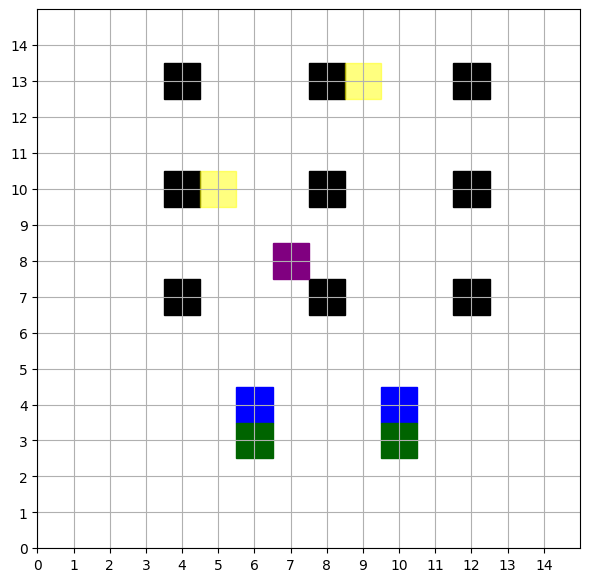

In [ ]:
env=RoverGridEnv()
print("Initial Setup")
observation=env.reset()
env.render()

# DDQN

In [ ]:
class rover_DDQN(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(rover_DDQN,self).__init__()
        self.net=nn.Sequential(
            nn.Linear(input_dim,256),nn.ReLU(),
            nn.Linear(256,128),nn.ReLU(),
            nn.Linear(128,output_dim))    
    def forward(self,x):
        return self.net(x)

In [ ]:
Transition=namedtuple('Transition',('stt','action','nxt_stt','rwd','done'))
class ReplayMemory(object):
    def __init__(self,capacity):
        self.memory=deque([],
                          maxlen=capacity)
    def push(self,*args):
        self.memory.append(Transition(*args))
    def sample(self,
               batch_size):
        return random.sample(self.memory,
                             batch_size)
    def __len__(self):
        return len(self.memory)

In [ ]:
def select_act(stt,policy_net,n_actions,stps_done,eps_begin,eps_end,eps_decay):
    sample=random.random()
    eps_threshold=eps_end+(eps_begin-eps_end)*np.exp(-1.*stps_done/eps_decay)
    stps_done+=1
    if sample>eps_threshold:
        with torch.no_grad():
            return policy_net(stt).max(1)[1].view(1,1),stps_done
    else:
        return torch.tensor([[random.randrange(n_actions)]],dtype=torch.long),stps_done

In [ ]:
def optimize_model_ddqn(memory,policy_net,target_net,optimizer,batch_size,gma):
    if len(memory) < batch_size:
        return
    transitions=memory.sample(batch_size)
    batch=Transition(*zip(*transitions))

    not_final_mask=torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.nxt_stt)),
                                        dtype=torch.bool)
    not_final_nxt_stt=torch.cat([s for s in batch.nxt_stt if s is not None])
    stt_batch=torch.cat(batch.state)
    act_batch=torch.tensor([list(act) for act in batch.action],
                           dtype=torch.long)
    rwd_batch=torch.cat(batch.reward)

    stt_act_values=policy_net(stt_batch).gather(1,
                                                act_batch)
    nxt_stt_act=policy_net(not_final_nxt_stt).max(1)[1].unsqueeze(1)
    nxt_stt_values=torch.zeros(batch_size)
    nxt_stt_values[not_final_mask]=target_net(not_final_nxt_stt).gather(1,
                                                                        nxt_stt_act).squeeze().detach()
    expected_stt_act_values=(nxt_stt_values.unsqueeze(1)*gma)+rwd_batch

    criterion=torch.nn.SmoothL1Loss()
    loss=criterion(stt_act_values,
                   expected_stt_act_values)
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1,1)
    optimizer.step()

In [ ]:
num_epis=1000
target_update=10
batch_size=256
gma=0.9
learning_r=0.001
eps_begin=1
eps_end=0.05
eps_decay=10000
steps_done=0
memory=ReplayMemory(10000)

In [ ]:
env_ddqn=RoverGridEnv(max_ts=30)

policy_net_ddqn=rover_DDQN(env_ddqn.observation_space.shape[0],
                           env_ddqn.action_space.n).float()
target_net_ddqn=rover_DDQN(env_ddqn.observation_space.shape[0],
                           env_ddqn.action_space.n).float()
target_net_ddqn.load_state_dict(policy_net_ddqn.state_dict())
target_net_ddqn.eval()
optimizer=optim.Adam(policy_net_ddqn.parameters(),
                     learning_r=learning_r)

In [ ]:
episode_rwds_ddqn=[]
epsilon_values_ddqn=[]

for episode in tqdm(range(num_epis),desc="Training Episodes"):
    state=env_ddqn.reset()
    state=torch.tensor(np.array([state]),dtype=torch.float)
    total_reward=0  
    
    for t in count():
        action_1,steps_done=select_act(state,policy_net_ddqn,
                                       env_ddqn.action_space.n,
                                       steps_done,
                                       eps_begin,
                                       eps_end,
                                       eps_decay)
        action_2,steps_done=select_act(state,policy_net_ddqn,
                                       env_ddqn.action_space.n,
                                       steps_done,
                                       eps_begin,
                                       eps_end,
                                       eps_decay) 
    
        nxt_stt,reward,done,_=env_ddqn.step((action_1.item(),
                                             action_2.item())) 
        nxt_stt=torch.tensor([nxt_stt],
                             dtype=torch.float)
        reward=torch.tensor([reward],
                            dtype=torch.float)
        
        total_reward+=reward.sum().item() 
        memory.push(state,
                    (action_1,action_2),
                    nxt_stt,
                    reward,
                    torch.tensor([done]))
        
        state=nxt_stt
        optimize_model_ddqn(memory,
                            policy_net_ddqn,
                            target_net_ddqn,
                            optimizer,
                            batch_size,
                            gma)
        if done:
            break
    if episode % target_update == 0:
        target_net_ddqn.load_state_dict(policy_net_ddqn.state_dict())
    
    episode_rwds_ddqn.append(total_reward)
    epsilon_values_ddqn.append(eps_end+(eps_begin-eps_end)*np.exp(-1.*steps_done/eps_decay))
print('Complete')

Training Episodes: 100%|██████████| 1000/1000 [03:45<00:00,  4.43it/s]

Complete


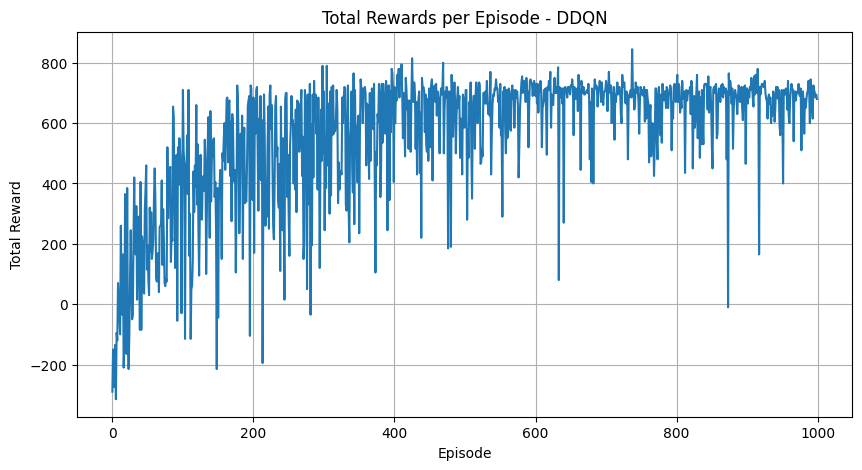

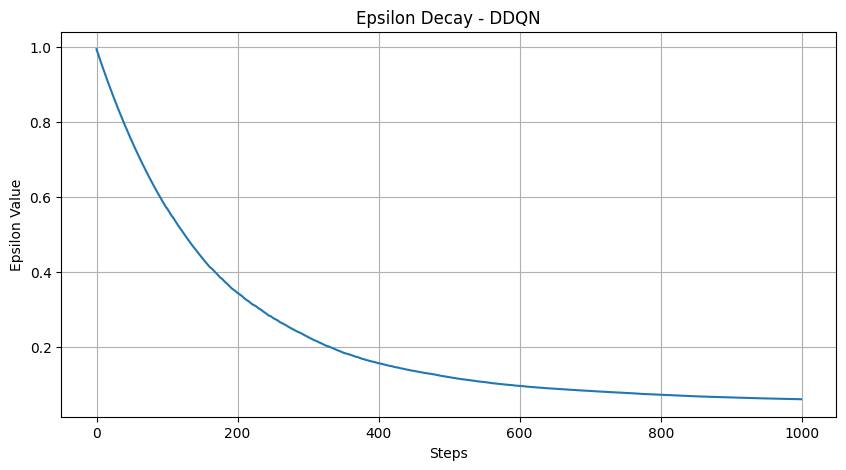

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(episode_rwds_ddqn)
plt.title('Total Rewards per Episode-DDQN')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(epsilon_values_ddqn)
plt.title('Epsilon Decay-DDQN')
plt.xlabel('Steps')
plt.ylabel('Epsilon Value')
plt.grid(True)
plt.show()

C:\Users\Kiyo\AppData\Local\Temp\ipykernel_8936\3272690895.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames = [imageio.imread(path) for path in frames_paths]


Episode 1 evaluated, GIF saved to eval_gifs_ddqn\episode_1.gif.
Episode 2 evaluated, GIF saved to eval_gifs_ddqn\episode_2.gif.
Episode 3 evaluated, GIF saved to eval_gifs_ddqn\episode_3.gif.
Episode 4 evaluated, GIF saved to eval_gifs_ddqn\episode_4.gif.
Episode 5 evaluated, GIF saved to eval_gifs_ddqn\episode_5.gif.
Episode 6 evaluated, GIF saved to eval_gifs_ddqn\episode_6.gif.
Episode 7 evaluated, GIF saved to eval_gifs_ddqn\episode_7.gif.
Episode 8 evaluated, GIF saved to eval_gifs_ddqn\episode_8.gif.
Episode 9 evaluated, GIF saved to eval_gifs_ddqn\episode_9.gif.
Episode 10 evaluated, GIF saved to eval_gifs_ddqn\episode_10.gif.


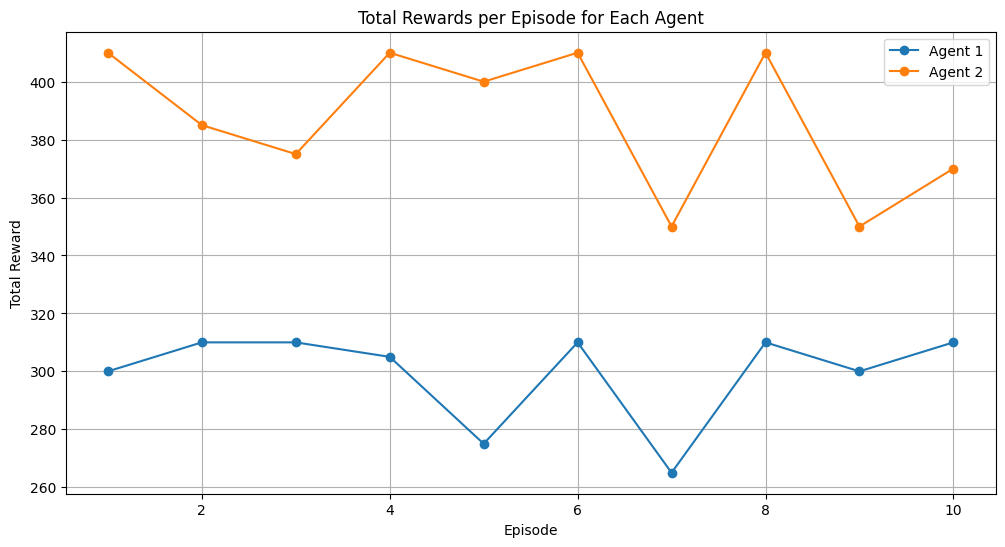

In [ ]:
def evaluate_agent(env_ddqn,policy_net_ddqn,num_epis=10,output_dir='eval_gifs_ddqn'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    epi_rwds_eval=[]     
    for episode in range(num_epis):
        state=env_ddqn.reset()
        episode_rwds_ddqn=np.zeros((2,))
        frames_paths=[]
        
        done=False
        timestep=0
        while not done:
            with torch.no_grad():
                state_tensor=torch.tensor([state],
                                          dtype=torch.float)
                action1=policy_net_ddqn(state_tensor).argmax().item()
                action2=policy_net_ddqn(state_tensor).argmax().item()

            nxt_stt,rewards,done,_=env_ddqn.step((action1,
                                                  action2))
            episode_rwds_ddqn+=rewards 
            state=nxt_stt
            
            frame_path=os.path.join(output_dir,f"episode_{episode+1}_frame_{timestep}.png")
            env_ddqn.render(save_path=frame_path) 
            frames_paths.append(frame_path)            
            timestep+=1
        
        epi_rwds_eval.append(episode_rwds_ddqn) 
    
        frames=[imageio.imread(path) for path in frames_paths]
        gif_path=os.path.join(output_dir,
                              f"episode_{episode+1}.gif")
        imageio.mimsave(gif_path,
                        frames,
                        fps=10)         
        for path in frames_paths:
            os.remove(path)

        print(f"Episode {episode+1} evaluated, GIF saved to {gif_path}.")

    epi_rwds_eval=np.array(epi_rwds_eval)  
    plt.figure(figsize=(12,6))
    for agent_index in range(2):
        plt.plot(range(1,num_epis+1),epi_rwds_eval[:,agent_index],marker='o',label=f'Agent {agent_index+1}')
    plt.title('Total Rewards per Episode for Each Agent')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir,'rewards_plot.png'))
    plt.show()

evaluate_agent(env_ddqn,policy_net_ddqn,num_epis=10)